In [ ]:
# !git clone https://github.com/fulifeng/Temporal_Relational_Stock_Ranking

In [ ]:
#@title Запуск модели
# Для запуска модели
# python relation_rank_lstm.py -rn wikidata -l 16 -u 64 -a 0.1

In [ ]:
# @title Открытие терминала
# from IPython.display import JSON
# from google.colab import output
# from subprocess import getoutput
# import os
# def shell(command):
#   if command.startswith('cd'):
#     path = command.strip().split(maxsplit=1)[1]
#     os.chdir(path)
#     return JSON([''])
#   return JSON([getoutput(command)])
# output.register_callback('shell', shell)

In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

In [1]:
%cd ..
%cd /content/drive/MyDrive/Курсовой проект/Temporal_Relational_Stock_Ranking/training

/
/content/drive/.shortcut-targets-by-id/12InUN6t4UOpqCu7-_03gOACcaz1UKnOE/Курсовой проект/Temporal_Relational_Stock_Ranking/training


In [2]:
import numpy as np
import os
# import psutil
import random
import torch
from time import time

from load_data import load_EOD_data, load_relation_data
from evaluator import evaluate

seed = 123456789
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_path = '../data/2013-01-01'
market_name = 'NASDAQ'
tickers_fname = market_name + '_tickers_qualify_dr-0.98_min-5_smooth.csv'
relation_name = 'wikidata'
emb_fname = 'NASDAQ_rank_lstm_seq-16_unit-64_2.csv.npy'
hist_length = 4
lstm_hid_units = 64
lr = 0.001
weight_of_rank_loss = 1
parameters = {'seq': hist_length, 'unit': lstm_hid_units, 'lr': lr,
              'alpha': weight_of_rank_loss}
steps = 1
epochs = 50
gpu = torch.cuda.is_available()
inner_prod = False

In [4]:
tickers = np.genfromtxt(os.path.join(data_path, '..', tickers_fname),
                                     dtype=str, delimiter='\t', skip_header=False)
print(tickers[:10])
print('#tickers selected:', len(tickers))

['AABA' 'AAON' 'AAPL' 'AAWW' 'AAXJ' 'AAXN' 'ABAX' 'ABCB' 'ABCO' 'ABMD']
#tickers selected: 1026


In [5]:
eod_data, mask_data, gt_data, price_data = load_EOD_data(data_path, market_name, tickers, steps)
print(eod_data.shape)
print(eod_data[0].shape)
print(eod_data[0])

single EOD data shape: (1245, 6)
(1026, 1245, 5)
(1245, 5)
[[0.270533 0.269522 0.267237 0.263333 0.275333]
 [0.271109 0.269741 0.26782  0.263982 0.271219]
 [0.271822 0.270097 0.268485 0.264723 0.272316]
 ...
 [0.948882 0.967983 0.969176 0.962736 0.951735]
 [0.949321 0.96472  0.968531 0.964939 0.962841]
 [0.952475 0.962416 0.969258 0.967535 0.976964]]


In [6]:
print(mask_data.shape)
print(mask_data[0].shape)
print(mask_data[0])

(1026, 1245)
(1245,)
[1. 1. 1. ... 1. 1. 1.]


In [7]:
print(gt_data.shape)
print(gt_data[0].shape)
print(gt_data[0])

(1026, 1245)
(1245,)
[ 0.         -0.01494191  0.00404479 ...  0.01878863  0.01166917
  0.01466807]


In [8]:
print(price_data.shape)
print(price_data[0].shape)
print(price_data[0])

(1026, 1245)
(1245,)
[0.275333 0.271219 0.272316 ... 0.951735 0.962841 0.976964]


In [9]:
rname_tail = {'sector_industry': '_industry_relation.npy',
              'wikidata': '_wiki_relation.npy'}

rel_encoding, rel_mask = load_relation_data(
                         # os.path.join(data_path, '..', 'relation', relation_name,
                         os.path.join(data_path, 'relation', relation_name,
                         market_name + rname_tail[relation_name])
                         )
print('relation encoding shape:', rel_encoding.shape)
print('relation mask shape:', rel_mask.shape)

relation encoding shape: (1026, 1026, 43)
relation encoding shape: (1026, 1026, 43)
relation mask shape: (1026, 1026)


In [10]:
rel_encoding[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [11]:
rel_mask

array([[ 0.e+00, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09,  0.e+00, -1.e+09, ..., -1.e+09, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09,  0.e+00, ..., -1.e+09, -1.e+09, -1.e+09],
       ...,
       [-1.e+09, -1.e+09, -1.e+09, ...,  0.e+00, -1.e+09, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09,  0.e+00, -1.e+09],
       [-1.e+09, -1.e+09, -1.e+09, ..., -1.e+09, -1.e+09,  0.e+00]])

In [12]:
valid_index = 756
test_index = 1008
trade_dates = mask_data.shape[1]
number_of_stocks = 1026
hidden_size = 256
# batch_size = len(tickers)
batch_size = 64
stock_indices = np.array([2, 19, 58, 377, 378, 464, 596])
tickers = tickers[stock_indices]
print(tickers)

['AAPL' 'ADBE' 'AMZN' 'GOOG' 'GOOGL' 'INTC' 'MSFT']


In [ ]:
# eod_data = eod_data[stock_indices]
# rel_encoding = rel_encoding[stock_indices]
# rel_encoding = rel_encoding[:, stock_indices]
# price_data = price_data[stock_indices]
# print(eod_data.shape)
# print(rel_encoding.shape)
# print(price_data.shape)

(7, 1245, 5)
(7, 7, 43)
(7, 1245)


In [ ]:
# tw = 30 # time window
# in_out_seq = []
# labels = []
# for stock_index in range(number_of_stocks):
#   single_in_out_seq = []
#   single_labels = []
#   num_examples = eod_data[stock_index].shape[0]
#   for j in range(num_examples - tw):
#     train_seq = eod_data[stock_index][j: j + tw]
#     train_label = gt_data[stock_index][j + tw]
#     single_in_out_seq.append(train_seq)
#     single_labels.append(train_label)
#   in_out_seq.append(single_in_out_seq)
#   labels.append(single_labels)
# in_out_seq = torch.tensor(np.array(in_out_seq))
# labels = torch.tensor(np.array(labels))
# print(in_out_seq.shape)
# print(in_out_seq[0][0])
# print(labels.shape)

In [13]:
tw = 10 # time window
in_out_seq = []
labels = []
for stock_index in stock_indices:
  single_in_out_seq = []
  single_labels = []
  num_examples = eod_data[stock_index].shape[0]
  for j in range(num_examples - tw):
    train_seq = price_data[stock_index][j: j + tw]
    train_label = price_data[stock_index][j + tw]
    single_in_out_seq.append(train_seq)
    single_labels.append(train_label)
  in_out_seq.append(single_in_out_seq)
  labels.append(single_labels)
in_out_seq = torch.tensor(np.array(in_out_seq)).unsqueeze(3)
labels = torch.tensor(np.array(labels))
print(in_out_seq.shape)
print(in_out_seq[0][0])
print(labels.shape)

torch.Size([7, 1235, 10, 1])
tensor([[0.4450],
        [0.4394],
        [0.4272],
        [0.4244],
        [0.4258],
        [0.4192],
        [0.4244],
        [0.4218],
        [0.4067],
        [0.3939]])
torch.Size([7, 1235])


In [14]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

In [15]:
train_datasets = []
train_dataloaders = []
val_datasets = []
val_dataloaders = []
test_datasets = []
test_dataloaders = []
for stock_index in range(len(stock_indices)):
  single_eod = in_out_seq[stock_index] # choose the single stock

  X_train = single_eod[:valid_index]
  y_train = labels[stock_index][:valid_index]
  train_dataset = MyDataset(X_train, y_train)
  train_datasets.append(train_dataset)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # create train dataloader
  train_dataloaders.append(train_dataloader)

  X_valid = single_eod[valid_index: test_index]
  y_valid = labels[stock_index][valid_index: test_index]
  val_dataset = MyDataset(X_valid, y_valid)
  val_datasets.append(val_dataset)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size) # create val dataloader
  val_dataloaders.append(val_dataloader)

  X_test = single_eod[test_index:]
  y_test = labels[stock_index][test_index:]
  test_dataset = MyDataset(X_test, y_test)
  test_datasets.append(test_dataset)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size) # create test dataloader
  test_dataloaders.append(test_dataloader)

In [16]:
print(len(train_dataloaders))
print(train_dataloaders[0])

7


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
import torch.nn as nn

class Model(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, batch_first=False, device='cpu'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.device = device
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=self.batch_first)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, batch):
        h0 = torch.zeros(self.num_layers, batch.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch.shape[0], self.hidden_size).to(device)
        out, (hn, cn) = self.lstm(batch, (h0, c0)) # out - 64 * 10 * 256
        last_emb = out[:, -1] # last_emb - 64 * 256
        scores = self.fc(last_emb).view(-1)
        return scores, last_emb

In [35]:
models = []
for i in range(len(stock_indices)):
  models.append(Model(input_size=1, hidden_size=hidden_size, num_layers=2, batch_first=True, device=device))

criterions = []
for i in range(len(stock_indices)):
  criterions.append(nn.MSELoss())

optimizers = []
for i in range(len(stock_indices)):
  optimizers.append(torch.optim.Adam(models[i].parameters(), lr=0.0001, weight_decay=1e-4))

train_losses = []
val_losses = []

eod_train_embeddings = torch.zeros(len(stock_indices), valid_index, hidden_size).to(device)
eod_val_embeddings = torch.zeros(len(stock_indices), test_index - valid_index, hidden_size).to(device)
eod_test_embeddings = torch.zeros(len(stock_indices), 1235 - test_index, hidden_size).to(device)

train_predictions = torch.zeros(len(stock_indices), valid_index).to(device)
val_predictions = torch.zeros(len(stock_indices), test_index - valid_index).to(device)
test_predictions = torch.zeros(len(stock_indices), 1235 - test_index).to(device)

In [36]:
print(train_predictions.shape)

torch.Size([7, 756])


In [174]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizers[0], 'min', patience=3)
for epoch in range(100):
  train_loss = 0
  val_loss = 0
  for stock_index in range(len(stock_indices)):
    batch_count = 0
    if epoch == 99:
      train_prediction = torch.tensor([]).to(device)
      train_eod_emb = torch.tensor([]).to(device)
    models[stock_index].train()
    models[stock_index].to(device)

    for single_x, single_y in train_dataloaders[stock_index]: # single_x - 64 * 10 * 1
      batch_count += 1
      optimizers[stock_index].zero_grad()
      output, embedding = models[stock_index](single_x.to(device))
      if epoch == 99:
        train_prediction = torch.cat((train_prediction, output), dim=0)
        train_eod_emb = torch.cat((train_eod_emb, embedding), dim=0)
      loss = criterions[stock_index](output, single_y.to(device))
      loss.backward()
      optimizers[stock_index].step()
      train_loss += loss.item()
    train_losses.append(train_loss / batch_count)
    train_loss = 0
    
    with torch.no_grad():
      batch_count = 0
      if epoch == 99:
        val_prediction = torch.tensor([]).to(device)
        val_eod_emb = torch.tensor([]).to(device)
      for single_x, single_y in val_dataloaders[stock_index]:
        batch_count += 1
        output, embedding = models[stock_index](single_x.to(device))
        if epoch == 99:
          val_prediction = torch.cat((val_prediction, output), 0)
          val_eod_emb = torch.cat((val_eod_emb, embedding), dim=0)
        loss = criterions[stock_index](output, single_y.to(device))
        val_loss += loss.item()
        # scheduler.step(val_loss)
      val_losses.append(val_loss / batch_count)
      val_loss = 0
    if epoch == 99:
      train_predictions[stock_index] = train_prediction
      eod_train_embeddings[stock_index] = train_eod_emb
      val_predictions[stock_index] = val_prediction
      eod_val_embeddings[stock_index] = val_eod_emb

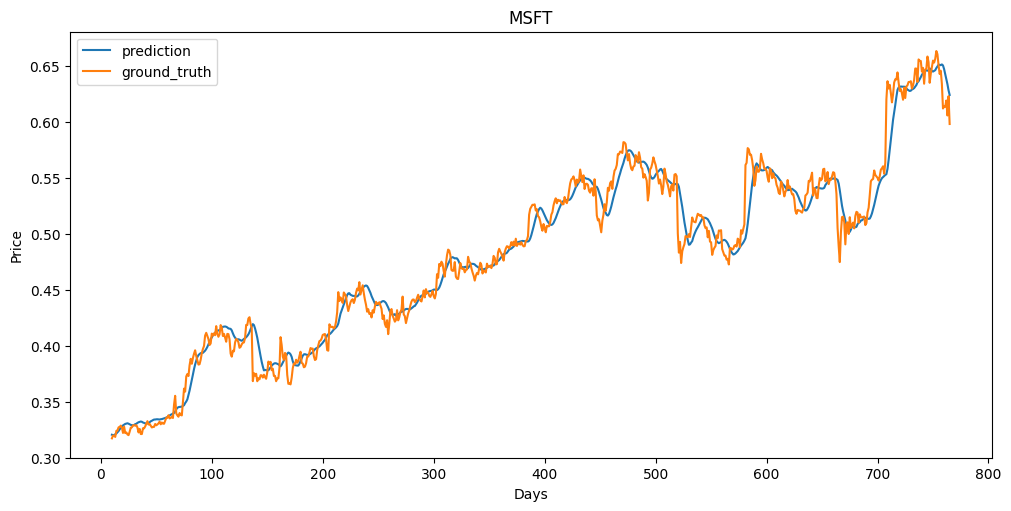

In [175]:
import matplotlib as mpl
import matplotlib.pyplot as plt

days = np.arange(valid_index) + tw

fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(days, train_predictions[6].cpu().detach().numpy(), label='prediction')
ax.plot(days, labels[6][:valid_index], label='ground_truth')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
ax.set_title(tickers[6])
ax.legend()

In [176]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(r2_score(labels[6][:valid_index], train_predictions[6].cpu().detach().numpy()))
print(mean_absolute_error(labels[6][:valid_index], train_predictions[6].cpu().detach().numpy()))
print(mean_squared_error(labels[6][:valid_index], train_predictions[6].cpu().detach().numpy()))

0.9697902009721895
0.009825994
0.00020871738


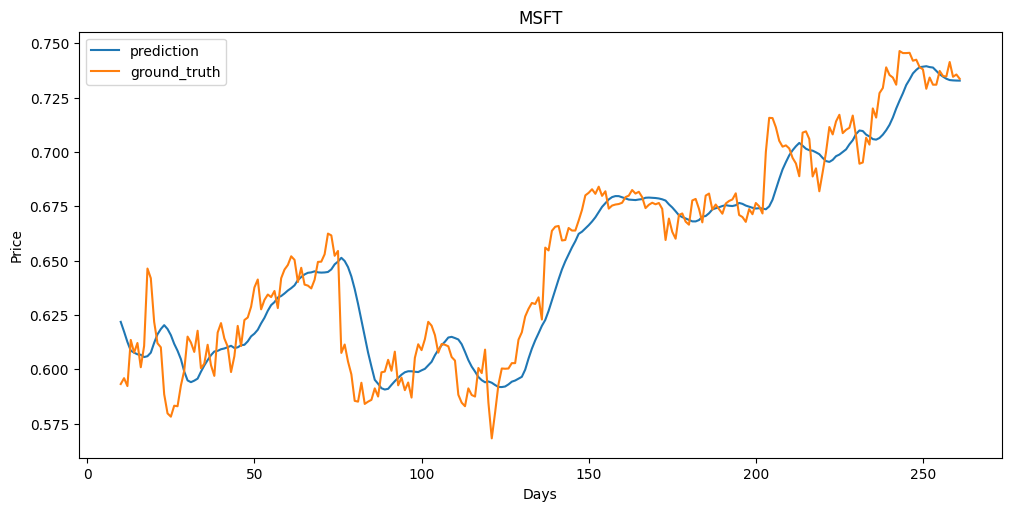

In [177]:
days = np.arange(test_index - valid_index) + tw
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(days, val_predictions[6].cpu().detach().numpy(), label='prediction')
ax.plot(days, labels[6][valid_index:test_index], label='ground_truth')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
ax.set_title(tickers[6])
ax.legend()

In [178]:
print(r2_score(labels[6][valid_index:test_index], val_predictions[6].cpu().detach().numpy()))
# print(mean_absolute_error(labels[0][:valid_index], train_predictions[0].cpu().detach().numpy()))
# print(mean_squared_error(labels[0][:valid_index], train_predictions[0].cpu().detach().numpy()))

0.8958298805673761


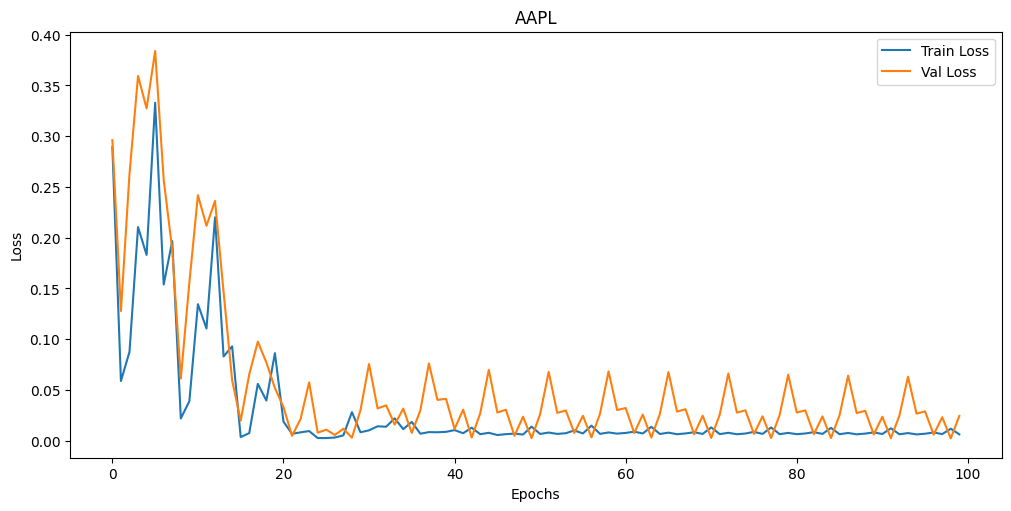

In [50]:
epochs = 100
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(np.arange(epochs), train_losses[:100], label='Train Loss')
ax.plot(np.arange(epochs), val_losses[:100], label='Val Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(tickers[0])
ax.legend()

In [179]:
test_prediction = torch.tensor([]).to(device)
test_eod_emb = torch.tensor([]).to(device)
# test_losses = []
stock_index = 6
with torch.no_grad():
    batch_count = 0
    for single_x, single_y in test_dataloaders[stock_index]:
      batch_count += 1
      output, embedding = models[stock_index](single_x.to(device))
      test_prediction = torch.cat((test_prediction, output), 0)
      test_eod_emb = torch.cat((test_eod_emb, embedding), dim=0)
      # loss = criterions[stock_index](output, single_y.to(device))
      # val_loss += loss.item()
    # val_losses.append(val_loss / batch_count)
    # val_loss = 0

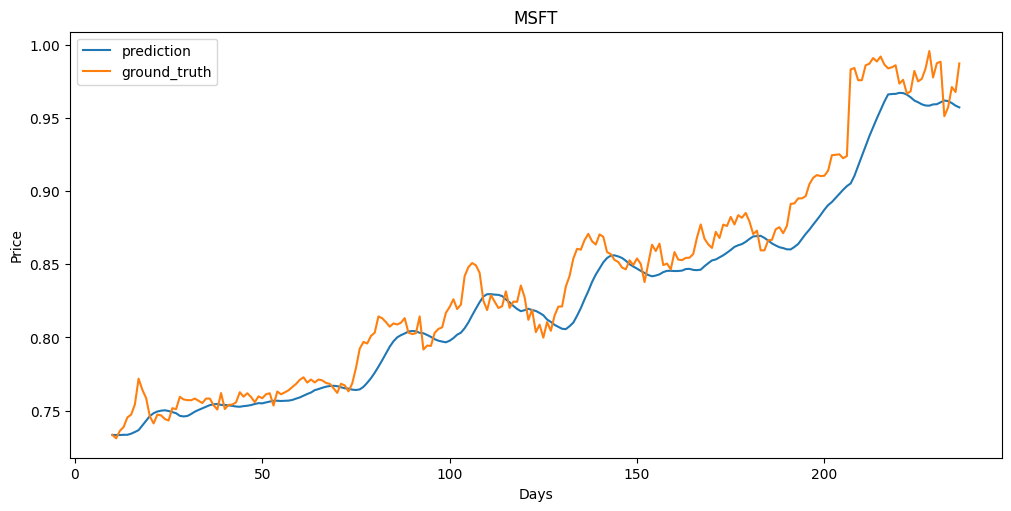

In [180]:
days = np.arange(1235 - test_index) + tw

fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(days, test_prediction.cpu().detach().numpy(), label='prediction')
ax.plot(days, labels[6][test_index:], label='ground_truth')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
ax.set_title(tickers[6])
ax.legend()

In [181]:
print(r2_score(labels[6][test_index:], test_prediction.cpu().detach().numpy()))

0.923297934401791


In [27]:
rel_encoding = rel_encoding[stock_indices]
rel_encoding = rel_encoding[:, stock_indices]
rel_encoding = torch.tensor(rel_encoding, dtype=torch.float32).to(device)
d_matrix = torch.sum(rel_encoding, (2,), dtype=torch.float32).to(device)
print(d_matrix.shape)

torch.Size([7, 7])


In [28]:
X_rel_train = in_out_seq[:, :valid_index]
y_rel_train = labels[:, :valid_index]
train_rel_dataset = MyDataset(X_train, y_train)
# train_rel_dataloader = DataLoader(train_rel_dataset, batch_size=batch_size) # create train dataloader

X_rel_valid = in_out_seq[:, valid_index: test_index]
y_rel_valid = labels[:, valid_index: test_index]
val_rel_dataset = MyDataset(X_rel_valid, y_rel_valid)
# val_rel_dataloader = DataLoader(val_rel_dataset, batch_size=batch_size) # create val dataloader

X_rel_test = in_out_seq[:, test_index:]
y_rel_test = labels[:, test_index:]
test_rel_dataset = MyDataset(X_rel_test, y_rel_test)
# test_rel_dataloader = DataLoader(test_rel_dataset, batch_size=batch_size) # create test dataloader

In [77]:
import torch.nn as nn

class RelModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, batch_first=False, device='cpu'):
      super().__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.batch_first = batch_first
      self.device = device
      self.lstm = nn.LSTM(input_size=self.input_size,
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          batch_first=self.batch_first)
      # self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
      self.in_features = 43
      self.fc_rel = nn.Linear(in_features=self.in_features, out_features=1, dtype=torch.float32)
      self.fc_end = nn.Linear(in_features=2 * self.hidden_size, out_features=1, dtype=torch.float32)

    def forward(self, batch, stock_index):
      eod_embeddings = torch.zeros(len(stock_indices), batch.shape[1], hidden_size).to(device) # 7 * 64 * 25
      for i in range(len(stock_indices)):
        h0 = torch.zeros(self.num_layers, batch.shape[1], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch.shape[1], self.hidden_size).to(device)
        out, (hn, cn) = self.lstm(batch[i], (h0, c0)) # out - 64 * 10 * 256
        last_emb = out[:, -1] # last_emb - 64 * 256
        eod_embeddings[i] = last_emb

      scores = torch.zeros(batch.shape[1]).to(device)
      for i in range(batch.shape[1]):
        similarity = (eod_embeddings[:, i, :] @ eod_embeddings[:, i, :].T).to(device)
        res_vec = torch.zeros(self.hidden_size, dtype=torch.float32).to(device)
        for j in range(len(stock_indices)):
          if d_matrix[stock_index][j] != 0:
            vec = rel_encoding[stock_index][j].to(device)
            # indices = (torch.arange(vec.shape[0]).to(device)[vec == 1]).to(device)
            # print('indices', indices)
            # for ind in indices:
            # print('sim', similarity[stock_index][ind])
            r = nn.ReLU()(self.fc_rel(vec))
            # print('rel', r)
            # print('emb', eod_embeddings[ind][i])
            # print('d', d_matrix[stock_index][ind])
            res_vec = similarity[stock_index][j] * r * eod_embeddings[j][i] / d_matrix[stock_index][j]
            # res_vec += similarity[stock_index][ind] * nn.ReLU()(self.fc_rel(vec)) * eod_embeddings[ind][i] / d_matrix[stock_index][ind]
        # print('res vec', res_vec)
        cat_vec = torch.cat((eod_embeddings[stock_index][i], res_vec), 0)
        score = self.fc_end(cat_vec)
        # print(score)
        scores[i] = score
      return scores

In [182]:
model = RelModel(input_size=1, hidden_size=hidden_size, num_layers=2, batch_first=True, device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
model.train()
model.to(device)

stock_index = 6
train_prediction = torch.tensor([]).to(device)
val_prediction = torch.tensor([]).to(device)
train_losses = []
val_losses = []

for epoch in range(100):
  train_loss = 0
  val_loss = 0
  batch_count = 0
  for i in range(0, valid_index, batch_size):
    batch_count += 1
    optimizer.zero_grad()
    x = X_rel_train[:, i: i + batch_size] # x - 7 * 64 * 10 * 1
    y = y_rel_train[:, i: i + batch_size]
    output = model(x.to(device), stock_index)
    if epoch == 99:
        train_prediction = torch.cat((train_prediction, output), dim=0)
    loss = criterion(output, y[stock_index].to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_losses.append(train_loss / batch_count)
  train_loss = 0
  
  with torch.no_grad():
    batch_count = 0
    for i in range(0, test_index - valid_index, batch_size):
      batch_count += 1
      x = X_rel_valid[:, i: i + batch_size] # x - 1026 * 64 * 10 * 1
      y = y_rel_valid[:, i: i + batch_size]
      output = model(x.to(device), stock_index)
      if epoch == 99:
        val_prediction = torch.cat((val_prediction, output), 0)
      loss = criterion(output, y[stock_index].to(device))
      val_loss += loss.item()
    val_losses.append(val_loss / batch_count)
    val_loss = 0

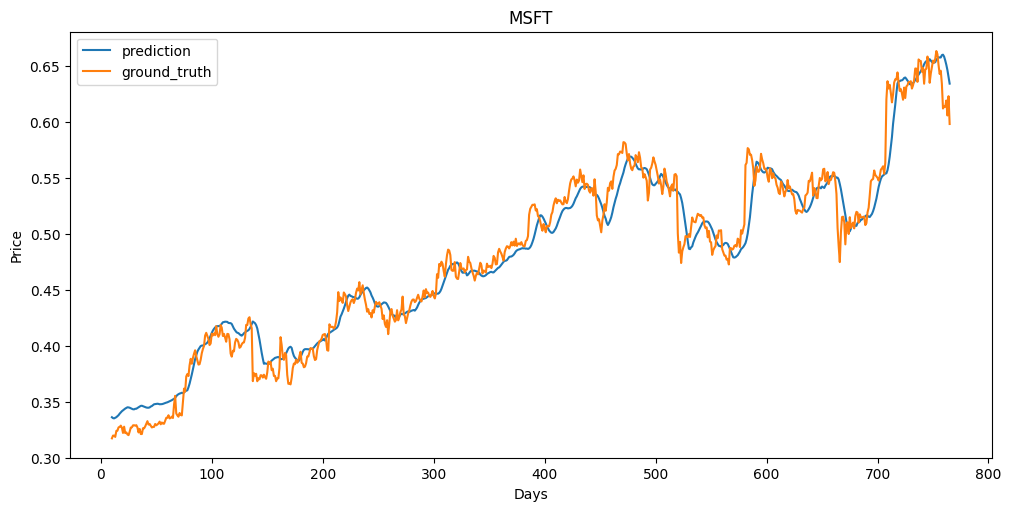

In [183]:
days = np.arange(valid_index) + tw

fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(days, train_prediction.cpu().detach().numpy(), label='prediction')
ax.plot(days, y_rel_train[6], label='ground_truth')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
ax.set_title(tickers[6])
ax.legend()

In [184]:
print(r2_score(y_rel_train[6], train_prediction.cpu().detach().numpy()))

0.9579250471391535


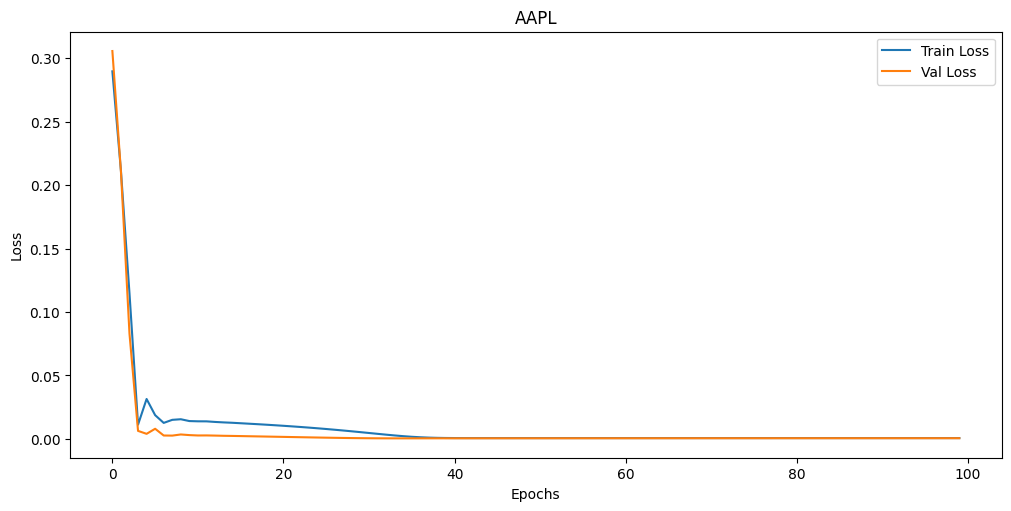

In [61]:
epochs = 100
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(np.arange(epochs), train_losses, label='Train Loss')
ax.plot(np.arange(epochs), val_losses, label='Val Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title(tickers[0])
ax.legend()

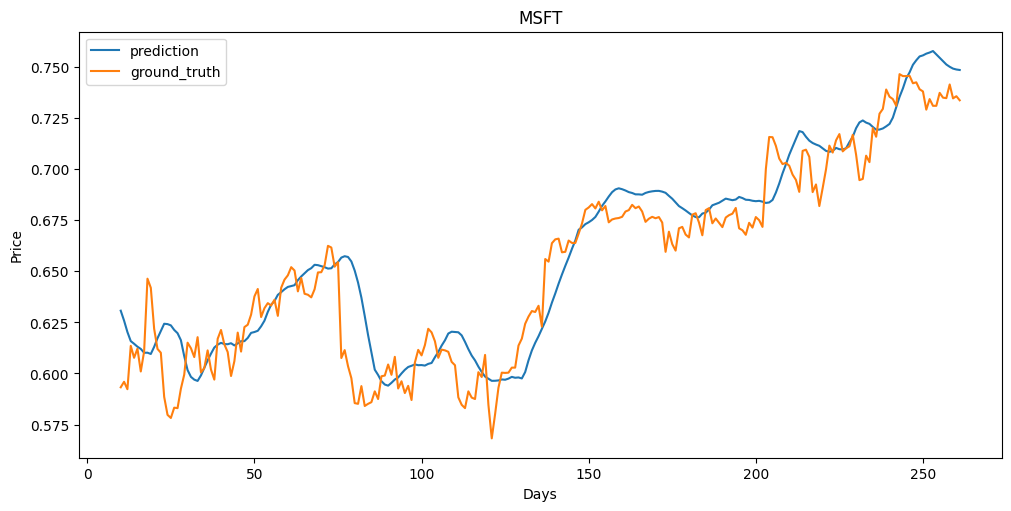

In [185]:
days = np.arange(test_index - valid_index) + tw

fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(days, val_prediction.cpu().detach().numpy(), label='prediction')
ax.plot(days, y_rel_valid[6], label='ground_truth')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
ax.set_title(tickers[6])
ax.legend()

In [186]:
print(r2_score(y_rel_valid[6], val_prediction.cpu().detach().numpy()))

0.8598569490913172


In [187]:
test_prediction = torch.tensor([]).to(device)
stock_index = 6
with torch.no_grad():
    for i in range(0, y_rel_valid.shape[1], batch_size):
      x = X_rel_test[:, i: i + batch_size] # x - 7 * 64 * 10 * 1
      y = y_rel_test[:, i: i + batch_size]
      output = model(x.to(device), stock_index)
      test_prediction = torch.cat((test_prediction, output), 0)

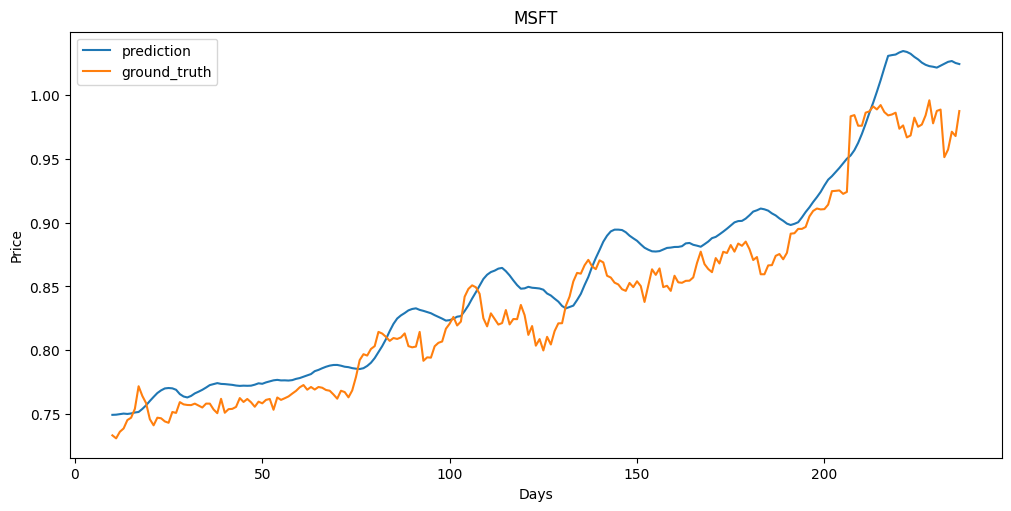

In [188]:
days = np.arange(y_rel_test.shape[1]) + tw

fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.plot(days, test_prediction.cpu().detach().numpy(), label='prediction')
ax.plot(days, y_rel_test[6], label='ground_truth')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
ax.set_title(tickers[6])
ax.legend()

In [189]:
print(r2_score(y_rel_test[6], test_prediction.cpu().detach().numpy()))

0.865858911385878
